## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plots_fabi import *
import sys
# Add functions path
sys.path.append('../Functions')

## Load Dataset

In [2]:
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset.csv', labels='category', samples_per_label=300)

### Dataframe for results
Create a dataframe, that contains all model results!

In [3]:
model_results = pd.DataFrame({'Preprocessing': ['Word Bagging', 'Word Embedding']})

## Prepare Dataset

In [4]:
df.shape

(2100, 9)

In [5]:
# TfidfVectorizer generates bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_tf: use logarithmic form for frequency
# min_df: minimum numbers of documents a word must be present to keep it
# ngram_range: number of ngrams to use
# stopwords: remove all common pronouns in given language

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()

labels = df.category

print('{} samples represented by {} features'.format(features.shape[0], features.shape[1]))

2100 samples represented by 13456 features


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], random_state = 42)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)
result = clf.score(X_test_tfidf, y_test)
model_results['NB'] = [result.round(3), None]
print(f"Accuracy for test set : {clf.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {clf.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 69.714%
Accuracy for train set: 82.540%


In [8]:
from sklearn.svm import SVC

svc = SVC().fit(X_train_tfidf, y_train)
result = svc.score(X_test_tfidf, y_test)
model_results['SVC'] = [result, None]
print(f"Accuracy for test set : {svc.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 69.714%
Accuracy for train set: 98.667%


In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier().fit(X_train_tfidf, y_train)
result = xgb.score(X_test_tfidf, y_test)
model_results['XGB'] = [result, None]
print(f"Accuracy for test set : {xgb.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {xgb.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 64.952%
Accuracy for train set: 94.413%


In [10]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train_tfidf, y_train)
result = svc.score(X_test_tfidf, y_test)
model_results['SVCLinear'] = [result, None]
print(f"Accuracy for test set : {svc.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 70.857%
Accuracy for train set: 99.746%


## Word Embeddings

In [11]:
import spacy
from time import time

## Word Embeddings (Word Vectors)

In [12]:
# Load loarge model
nlp = spacy.load('en_core_web_lg')

# Disabling other pipes, no need for them, takes too much time
with nlp.disable_pipes():
    vectors = np.array([nlp(text).vector for text in df.text])

In [13]:
vectors.shape

(2100, 300)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df['category'], random_state = 42)

In [15]:
svc = SVC().fit(X_train, y_train)
result = svc.score(X_test, y_test)
model_results.loc[1, 'SVC'] = result
print(f"Accuracy for test set : {svc.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 66.476%
Accuracy for train set: 65.841%


In [16]:
xgb = XGBClassifier().fit(X_train, y_train)
result = xgb.score(X_test, y_test)
model_results.loc[1, 'XGB'] = result
print(f"Accuracy for test set : {xgb.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {xgb.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 65.333%
Accuracy for train set: 97.333%


In [17]:
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)
result = svc.score(X_test, y_test)
model_results.loc[1, 'SVCLinear'] = result
print(f"Accuracy for test set : {svc.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 68.952%
Accuracy for train set: 77.016%


In [18]:
model_results.round(3)

,Preprocessing,NB,SVC,XGB,SVCLinear
0,Word Bagging,0.697,0.697,0.650,0.709
1,Word Embedding,NaN,0.665,0.653,0.690


### SVC different categories

In [20]:
# Load training set
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset.csv', labels='category', samples_per_label=800)
# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)
mid = int(df.shape[0]/2)
X_train, y_train = df[:mid].text, df[:mid].category

# Load test set for every category
df = df[mid:]
test_set = {}
for i in df.category.unique():
    test_set[i] = df[df['category'] == i].text.values

In [21]:
# Fit model
svc = SVC()
X_train_tfidf = tfidf.fit_transform(X_train)
svc.fit(X_train_tfidf, y_train)

predictions = []
# Get accuracies for categories
for key, value in test_set.items():
    X_test_tfidf = tfidf.transform(value)
    y_test = np.full(value.shape[0], key)
    print('Score for category {: <13}:   {:.1f} %'.format(key, svc.score(X_test_tfidf, y_test)*100))
    # Get Predictions
    cat, val = np.unique(svc.predict(X_test_tfidf), return_counts=True)
    #pred = sorted(list(zip(cat, (val/y_test.shape[0]*100).round(1))) , key=lambda x: x[1], reverse=True)
    predictions.append((cat, (val/y_test.shape[0]*100).round(1)))

Score for category entertainment:   70.5 %
Score for category technology   :   74.2 %
Score for category sports       :   70.7 %
Score for category travel       :   71.9 %
Score for category world        :   69.8 %
Score for category politics     :   62.5 %
Score for category financial    :   69.3 %


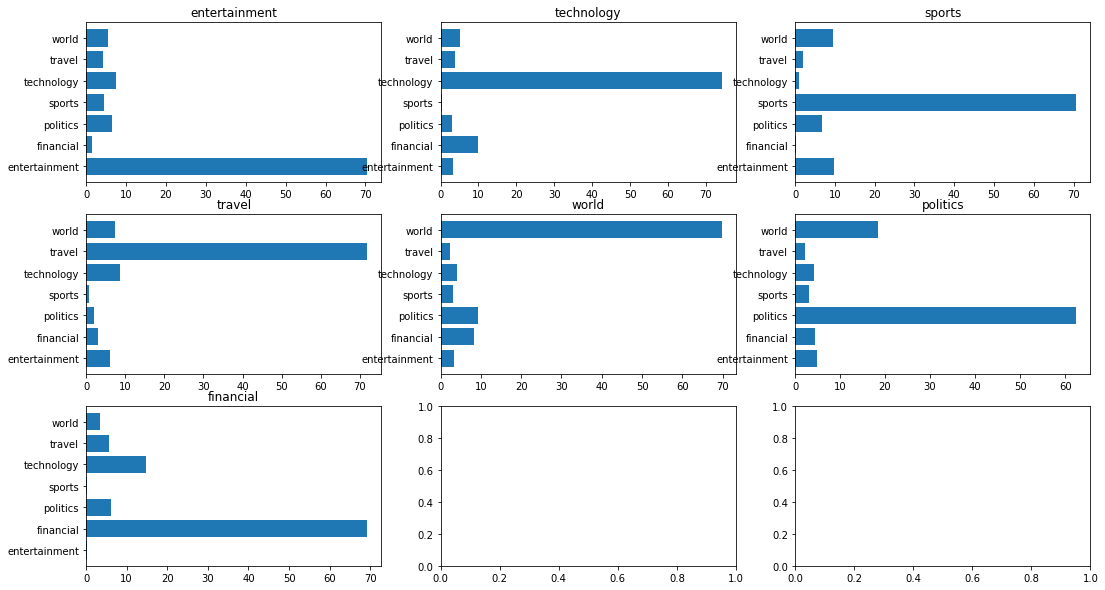

In [22]:
fig, ax = plt.subplots(3,3,figsize=(18,10))
simple_h_bar(predictions[0][0], predictions[0][1], ax=ax[0][0], title=predictions[0][0][np.argmax(predictions[0][1])])
simple_h_bar(predictions[1][0], predictions[1][1], ax=ax[0][1], title=predictions[1][0][np.argmax(predictions[1][1])])
simple_h_bar(predictions[2][0], predictions[2][1], ax=ax[0][2], title=predictions[2][0][np.argmax(predictions[2][1])])
simple_h_bar(predictions[3][0], predictions[3][1], ax=ax[1][0], title=predictions[3][0][np.argmax(predictions[3][1])])
simple_h_bar(predictions[4][0], predictions[4][1], ax=ax[1][1], title=predictions[4][0][np.argmax(predictions[4][1])])
simple_h_bar(predictions[5][0], predictions[5][1], ax=ax[1][2], title=predictions[5][0][np.argmax(predictions[5][1])])
simple_h_bar(predictions[6][0], predictions[6][1], ax=ax[2][0], title=predictions[6][0][np.argmax(predictions[6][1])])

### Accuracy in dependence of training size

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

svc = SVC()

# Load loarge model
nlp = spacy.load('en_core_web_lg')

samples = []
word_bagging = []
word_embedding = []
for num_samples in [10, 100, 300, 450]:
    start_time = time()
    
    samples.append(num_samples)
    
    df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset.csv', labels='category', samples_per_label=num_samples)

    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], random_state = 42)

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    svc.fit(X_train_tfidf, y_train)
    result = svc.score(X_test_tfidf, y_test)
    word_bagging.append(result)

    # Disabling other pipes, no need for them, takes too much time
    with nlp.disable_pipes():
        vectors = np.array([nlp(text).vector for text in df.text])

    X_train, X_test, y_train, y_test = train_test_split(vectors, df['category'], random_state = 42)

    svc.fit(X_train, y_train)
    result = svc.score(X_test, y_test)
    word_embedding.append(result)
    
    print('Calculation with {} samples finished in {:.1f}s'.format(num_samples, time()-start_time))

Calculation with 10 samples finished in 14.4s
Calculation with 100 samples finished in 61.9s
Calculation with 300 samples finished in 176.7s
Calculation with 450 samples finished in 272.9s


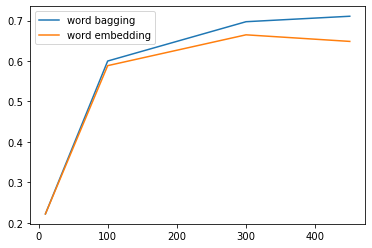

In [25]:
plt.plot(samples, word_bagging, label='word bagging')
plt.plot(samples, word_embedding, label='word embedding')
plt.legend();